# Final Project Submission
- Student Name - Vinayak Modgil
- Student pace - Full time
- Scheduled project review time/date -
- Instructor name - Yish Lim
- Plog Post URL - 

# Table of Contents
- [Introduction](#Introduction)
- [Data Collection](#Data-Collection)
- [Data Cleaning](#Data-Cleaning)
- [Data Exploration](#Data-Exploration)
- [Data Modeling](#Data-Modeling)
- [Data Interpretation](#Data-Interpretation)
- [Recommendations and Conclusions](#Recommendations-and-Conclusions)

# Introduction

# Data Collection

## Import necessary packages

In [ ]:
import pandas as pd
import os, sys, glob
import cv2

#Data wrangling packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#Neural Network packages
import tensorflow as tf

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

#Data evaluation metrics packages
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

#ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Deep Learning hyperparameter tuning
import talos

import lime
from lime import lime_image
from lime import lime_base


In [45]:
train_folder = "data/chest_xray/chest_xray/train"
test_folder = "data/chest_xray/chest_xray/test"
val_folder = "data/chest_xray/chest_xray/val"

In [46]:
def n_images_identifier(base_folder="data/chest_xray/chest_xray/"):
    '''
    returns the number of different
    types of images in the folders
    
    n_images_identifies: 
    - base folder : common folder holding all the images.
    '''
    #Takes the folder type as normal or pneumonia
    folder_type = ["NORMAL", "PNEUMONIA"]
    #
    train_folder = base_folder + "train/"
    test_folder = base_folder + "test/"
    val_folder = base_folder + "val/"
    
    # iterates for folder in train_folder, test_folder
    #and val_folder
    for folder in [train_folder, test_folder, val_folder]:
        
        #Further iterates for _type in folder_type
        for _type in folder_type:
            if _type=="NORMAL":
                n_normal = len(os.listdir(folder + _type))
            else:
                n_infected = len(os.listdir(folder + _type))
        print(f"Set: {folder}, normal images: {n_normal}, infected images: {n_infected}")
        print(f"Folder {folder} has a total of {n_normal+n_infected} images\n")

        plt.figure(figsize=(6, 6))
        sns.barplot(["Normal", "Pneumonia"], [n_normal, n_infected])
        plt.ylabel("Number of images", fontsize=14)
        plt.title(f"{folder} distribution", fontsize=16)
    print("Class imbalance for train and test set")
    return 
    

Set: data/chest_xray/chest_xray/train/, normal images: 1342, infected images: 3876
Folder data/chest_xray/chest_xray/train/ has a total of 5218 images

Set: data/chest_xray/chest_xray/test/, normal images: 234, infected images: 390
Folder data/chest_xray/chest_xray/test/ has a total of 624 images

Set: data/chest_xray/chest_xray/val/, normal images: 9, infected images: 9
Folder data/chest_xray/chest_xray/val/ has a total of 18 images

Class imbalance for train and test set


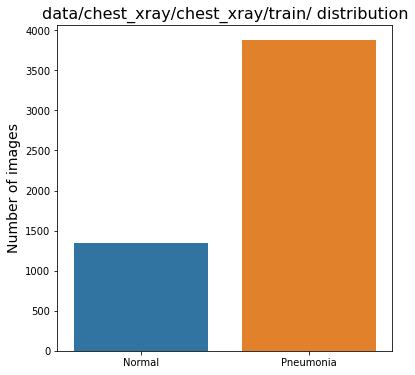

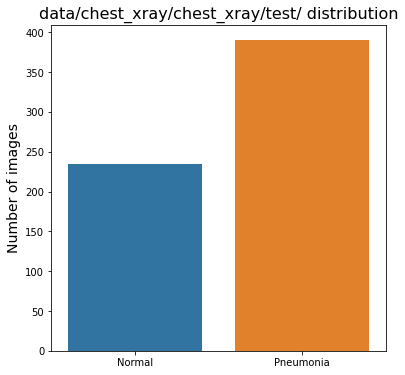

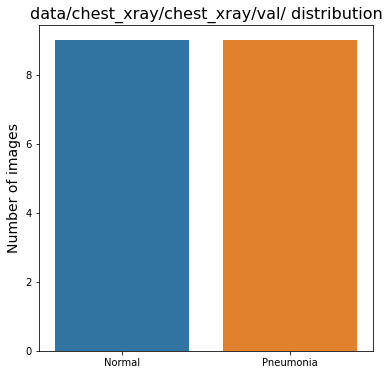

In [47]:
n_images_identifier()

In [48]:
def data_processing(img_dims,
                    batch_size=None,
                    base_folder="data/chest_xray/chest_xray/"):
    train_folder = base_folder + "train/"
    test_folder = base_folder + "test/"
    val_folder = base_folder + "val/"

    #Data genereation objects
    train_images = ImageDataGenerator(rescale=1./255)
    test_val_images = ImageDataGenerator(rescale=1./255, validation_split=0.2,)
    
    
    #Use flow from directory to get train and test 
    #images
    if batch_size != None:

        train_chest = train_images.flow_from_directory(
        directory=train_folder,
        target_size=(img_dims, img_dims),
        batch_size=batch_size, 
        classes = ["NORMAL", "PNEUMONIA"],
        class_mode="binary", 
        shuffle=False)
    
        test_chest = test_val_images.flow_from_directory(
        directory=test_folder, 
        target_size=(img_dims, img_dims),
        subset="training",
        batch_size=batch_size, 
        classes=["NORMAL", "PNEUMONIA"],
        class_mode="binary", 
        shuffle=False)

        val_chest = test_val_images.flow_from_directory(
        directory=test_folder,
        target_size=(img_dims, img_dims),
        subset="validation",
        batch_size = batch_size,
        classes=["NORMAL", "PNEUMONIA"],
        class_mode="binary",
        shuffle=False)

        return train_chest, test_chest, val_chest, batch_size

In [49]:
train_gen, test_gen, val_gen, batch_size= data_processing(80, batch_size=32)

Found 5216 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [50]:
import matplotlib.image as mpimg

def plot_images(path, max_images=6):
    amount = 0
    fig =  plt.figure(figsize=(12, 6))
    for file in os.listdir(path):
        if file.endswith(".jpeg"):
           if amount == max_images:
               break
           img = mpimg.imread(os.path.join(path, file))
           plt.subplot(230+1+amount)
           plt.title(path[33:])
           imgplot = plt.imshow(img)

           amount += 1




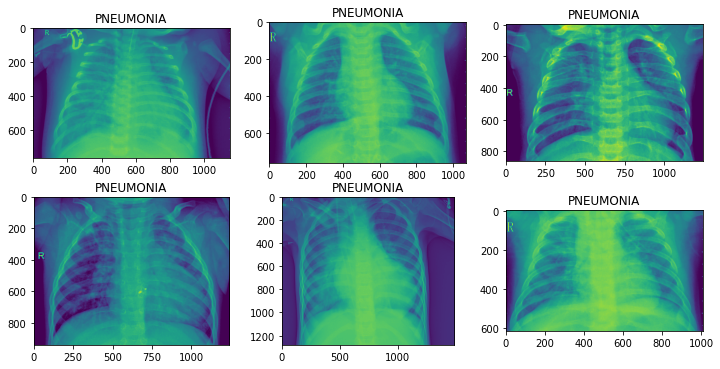

In [51]:
plot_images(path = train_folder + "/PNEUMONIA")

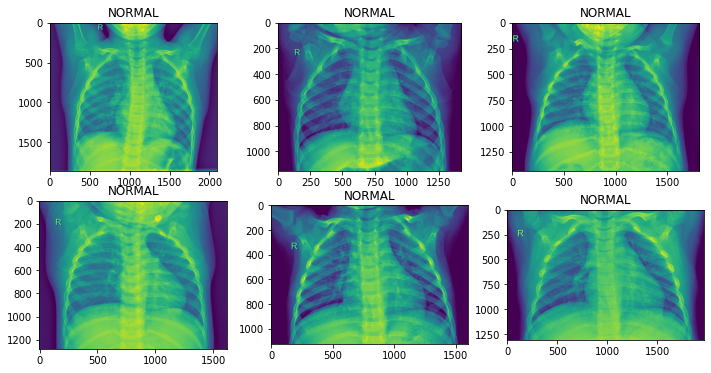

In [52]:
plot_images(train_folder+"/NORMAL")

I create a class of Convolutional Neural Network model which will contain functions created from the use of Tensorflow to help build us our model.

In [53]:
# class CNN_model:
#     '''
#     Using OOP to create a class for Convolutional Neural
#     Network.
#     '''

#     def add_weights(self, shape):
#         '''
#         A method to create weight connections for all 
#         the layers.
#         '''

#         return tf.Variable(tf.random.truncated_normal(shape=shape, stddev=0.05))

#     def bias(self, shape):
#         '''a method to create biases for all the connections'''

#         return tf.Variable(tf.constant(0.05, shape=shape))
    
#     def conv_layer(self, prev_layer, kernel, input_shape,output_shape, stride):
#         '''create convolution layers with the weights'''
#         weights = self.add_weights([kernel, kernel, input_shape, output_shape])

#         bias = self.bias([output_shape])

#         stride = [1, stride, stride, 1]
        
#         c_layer = tf.nn.conv2d(prev_layer, weights, stride, padding="SAME") + bias
#         return c_layer
    
#     def pooling_layer(self, c_layer, size, stride_s):
#         '''create the pooling layer'''
#         kernel =[1, size, size, 1]
#         stride = [1, stride_s, stride_s, 1]
#         p_layer = tf.nn.max_pool(c_layer, kernel, stride, padding="SAME")
#         return p_layer

#     def flat_layer(self, prev_layer):
#         '''A method to flatten the 2D features into single dimension'''
#         input_size = prev_layer.get_shape().as_list()
#         output_size = input_size[-1]*input_size[-2]*input_size[-3]
#         return tf.reshape(prev_layer, [-1, output_size]), output_size
    
#     def fc_layer(self, prev_layer, input_shape, output_shape):
#         '''Creates fully connected layer'''
#         weights = self.add_weights([input_shape, output_shape])
#         bias = self.bias([output_shape])
#         fc = tf.add(tf.matmul(prev_layer, weights), bias)
#         return fc
    
#     def activation(self, layer):
#         '''We define the activation layer which uses the relu activation function'''
#         return tf.nn.relu(layer)

#     def dropout(self, layer):
#         ''''''
#         return tf.nn.dropout(layer, 0.5)




In [54]:
# def create_CNN(image, number_of_class):
#     # create the first convolutional layer
#     c1 = CNN_model.conv_layer(image, 5, 8, 16, 1)
#     p1 = CNN_model.pooling_layer(c1, 5, 2)
#     l1 = CNN_model.activation(p1)

#     #Create second convolutional layer
#     c2 = CNN_model.conv_layer(l1, 4, 16, 32, 1)
#     p2 = CNN_model.pooling_layer(c2, 5, 2)
#     l2 = CNN_model.activation(p2)

#     #Create third convolutional layer
#     c3 = CNN_model.conv_layer(l2, 3, 32, 64, 1)
#     p3 = CNN_model.pooling_layer(c3, 5, 2)
#     l3 = CNN_model.activation(p3)

# #Convert the 2D activations into single vector
#     emb1, length = CNN_model.flat_layer(l3)

# #Feed the network to the fully connected layer
#     emb2 = CNN_model.fc_layer(emb1, length, 1024)

# # Compute the activation
#     emb3 = CNN_model.activation(emb2) #Apply dropout
#     emb4 = CNN_model.dropout(emb3)  # Output layer

# #feed the previous activations to the output layer
#     net = CNN_model.fc_layer(emb3, 1024, number_of_class)
#     print(net)
#     return net

    


In [55]:
# session = tf.compat.v1.Session()

# def trainer(number_of_images):

#     z_train = create_CNN(train_images, 2)
#     z_test = create_CNN(test_images, 2)
#     z_val = create_CNN(val_images, 2)
    
#     y = tf.nn.softmax(z)

#     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=z),
#     labels=train_labels)

#     tf.summary.scalar("cost", cost)

#     optimizer = tf.train.AdamOptimizer().minimize(cost)

#     correct_prediction = tf.equal(tf.argmax(train_labels, 1),tf.argmax(y, 1))

#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#     # initialize the optimizer
#     session.run(tf.global_variables_initializer())

#     merged = tf.summary.merge_all()

#     saver = tf.train.Saver(max_to_keep = 4)

#     total_batch_train = batch_size_train
#     total_batch_test = batch_size_test
#     total_batch_val = batch_size_val








## Data Preparation for Modeling

In [56]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(val_gen.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [57]:
train_size = len(train_gen.filenames)
test_size = len(test_gen.filenames)
val_size = len(val_gen.filenames)

train_size, test_size, val_size


(5216, 500, 124)

In [58]:
# def cnn_model(train_img, train_y, test_img, test_y):

#     model = Sequential()

#     ## hidden layers
#     model.add(Conv2D(params["nodes_cnn"], (3, 3),
#     activation=params["activation_cnn"],
#     input_shape=(80, 80, 3)))
#     model.add(MaxPooling2D((2, 2)))
#     #


### Basline Model


In [59]:
## Initializing the CNN
def baseline_model():
        model = Sequential()

#Add a convolution layer with 32 kernels of 3x2 shape
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(80, 80, 3)))

        model.add(MaxPooling2D((2, 2)))

# Add another convolution layer
        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D((2,2)))

        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D((2, 2)))

#Flattening the layer before fully connected layers
        model.add(Flatten())

#Fully connected layer with 256 neurons
        model.add(Dense(256, activation="relu"))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy",
              optimizer="RMSprop",
              metrics=["accuracy"])
        model.summary()
        return model

In [60]:
model = baseline_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)             

In [61]:
history = model.fit_generator(train_gen,
                              epochs=10,
                              steps_per_epoch=train_size//batch_size,
                              validation_steps=val_size//batch_size,
                              validation_data=val_gen)

Epoch 1/10
163/163 [==============================] - 71s 427ms/step - loss: 0.7466 - accuracy: 0.7536 - val_loss: 1.1379 - val_accuracy: 0.5104
Epoch 2/10
163/163 [==============================] - 64s 391ms/step - loss: 0.3776 - accuracy: 0.8620 - val_loss: 1.8160 - val_accuracy: 0.5625
Epoch 3/10
163/163 [==============================] - 64s 393ms/step - loss: 0.2449 - accuracy: 0.9153 - val_loss: 5.9357 - val_accuracy: 0.5208
Epoch 4/10
163/163 [==============================] - 64s 395ms/step - loss: 0.2532 - accuracy: 0.9260 - val_loss: 1.2110 - val_accuracy: 0.6458
Epoch 5/10
163/163 [==============================] - 64s 393ms/step - loss: 0.1791 - accuracy: 0.9379 - val_loss: 2.8150 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 64s 394ms/step - loss: 0.1568 - accuracy: 0.9473 - val_loss: 1.8397 - val_accuracy: 0.5833
Epoch 7/10
163/163 [==============================] - 110s 680ms/step - loss: 0.1382 - accuracy: 0.9561 - val_loss: 1.0754 - val_a

In [62]:
history.history

{'loss': [0.7466364502906799,
  0.3776295781135559,
  0.2449132800102234,
  0.2531910538673401,
  0.1791101098060608,
  0.15682388842105865,
  0.13824279606342316,
  0.11649896949529648,
  0.08888251334428787,
  0.0888717919588089],
 'accuracy': [0.7536426186561584,
  0.8619632124900818,
  0.9152607321739197,
  0.9259969592094421,
  0.9378834366798401,
  0.9472776055335999,
  0.9560966491699219,
  0.95820552110672,
  0.9662576913833618,
  0.9706671833992004],
 'val_loss': [1.1378960609436035,
  1.8160486221313477,
  5.935707092285156,
  1.2109663486480713,
  2.8149845600128174,
  1.8397365808486938,
  1.0753954648971558,
  0.9308921694755554,
  5.876092433929443,
  0.9672651290893555],
 'val_accuracy': [0.5104166865348816,
  0.5625,
  0.5208333134651184,
  0.6458333134651184,
  0.5625,
  0.5833333134651184,
  0.71875,
  0.78125,
  0.5416666865348816,
  0.78125]}

In [114]:
def model_eval(model, history):
    train_loss = history.history['loss']
    validation_loss = history.history["val_loss"]

    train_accuracy = history.history["accuracy"]
    validation_accuracy = history.history["val_accuracy"]

    #line plot of train_accuracy
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

    #plotting accuracy
    ax[0].plot(train_accuracy, label="Training accuracy", color="red")
    ax[0].plot(validation_accuracy, label="Validation accuracy", color="green")
    ax[0].legend()

    #Plotting loss
    ax[1].plot(train_loss, label="Training loss", color="red")
    ax[1].plot(validation_loss, label = "validation loss", color="green")
    ax[1].legend()
    plt.show()

    predictions = model.predict_generator(test_gen, steps = test_size/batch_size)

    y_pred = (predictions> 0.5).astype(int)
    y_true = test_gen.classes

    #Getting classification report
    print("***"*10)
    print("Classification Report")
    print("***"*10)

    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

    #Plotting confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["NORMAL", "PNEUMONIA"])
    ax.yaxis.set_ticklabels(["NORMAL", "PNEUMONIA"])
    plt.show()

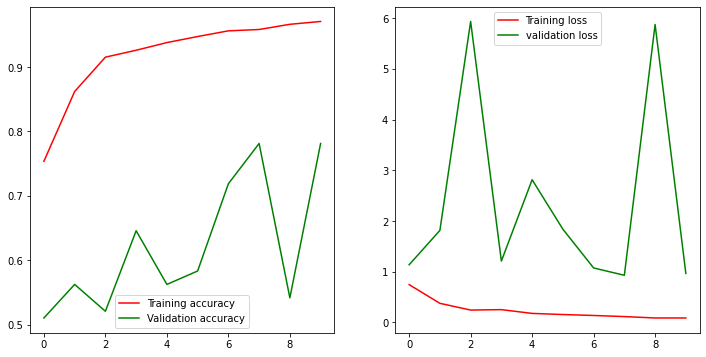

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.94      0.52      0.67       188
   PNEUMONIA       0.77      0.98      0.86       312

    accuracy                           0.81       500
   macro avg       0.86      0.75      0.77       500
weighted avg       0.84      0.81      0.79       500



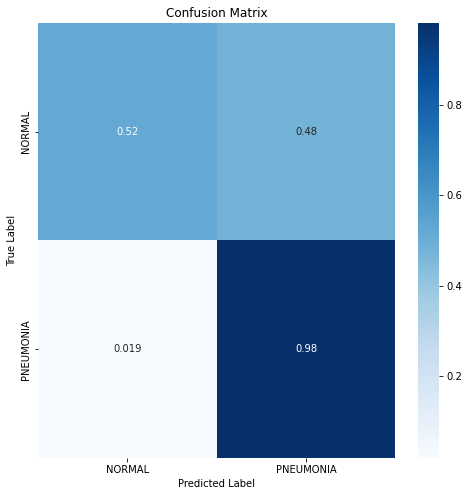

In [115]:
model_eval(model, history)

Looking at this model, we can see that the accuracy is 81%, which is decent for a baseline model, and it can predict 98% of the pneumonia cases. The model has a high rate of false positive test results (48%) which means that the ability of the model to predict normal xray images is limited.

## Model 1


In [123]:
def model_1st():
     model_1 = Sequential()

     #Adding convolution layer no 1
     model_1.add(Conv2D(32, kernel_size=(3,3), padding="same", activation="relu",input_shape=(80,80,3)))
     #Adding a MaxPooling layer
     model_1.add(MaxPooling2D((2,2)))
     #Add Convolution layer no 2
     model_1.add(Conv2D(63, kernel_size=(3,3), padding="same", activation="relu"))
     #Add a MaxPooling layer
     model_1.add(MaxPooling2D((2,2)))
     #Add convolution layer no 3
     model_1.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
     #Add a MaxPooling layer
     model_1.add(MaxPooling2D((2,2)))
     #Add convolution layer no 4
     model_1.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
     #Add a maxpooling layer
     model_1.add(MaxPooling2D((2,2)))

     #Flatten the layer
     model_1.add(Flatten())
     #Add a fully connected layer
     model_1.add(Dense(64, activation="relu"))
     model_1.add(Dense(128, activation="relu"))
     model_1.add(Dense(256, activation="relu"))
     model_1.add(Dense(512, activation="relu"))

     model_1.add(Dense(1, activation="sigmoid"))

     model_1.compile(loss="binary_crossentropy",optimizer="RMSprop", metrics=["acc"])

     model_1.summary()
     return model





In [130]:
model_1 = model_1st()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 40, 40, 63)        18207     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 20, 20, 63)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 20, 128)       72704     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 10, 128)      

In [131]:
history = model_1.fit_generator(train_gen, epochs=10,
                             steps_per_epoch=train_size//batch_size,
                             validation_steps=val_size//batch_size,
                             validation_data=val_gen)

Epoch 1/10
163/163 [==============================] - 114s 701ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 4.4739 - val_accuracy: 0.6979
Epoch 2/10
163/163 [==============================] - 126s 771ms/step - loss: 0.0127 - accuracy: 0.9952 - val_loss: 4.5476 - val_accuracy: 0.7188
Epoch 3/10
163/163 [==============================] - 126s 772ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 4.5671 - val_accuracy: 0.7396
Epoch 4/10
163/163 [==============================] - 107s 655ms/step - loss: 0.0063 - accuracy: 0.9973 - val_loss: 6.1793 - val_accuracy: 0.6458
Epoch 5/10
163/163 [==============================] - 78s 478ms/step - loss: 0.0133 - accuracy: 0.9967 - val_loss: 3.7221 - val_accuracy: 0.7917
Epoch 6/10
163/163 [==============================] - 78s 471ms/step - loss: 0.0077 - accuracy: 0.9971 - val_loss: 7.7195 - val_accuracy: 0.6562
Epoch 7/10
163/163 [==============================] - 62s 377ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 5.7010 - va

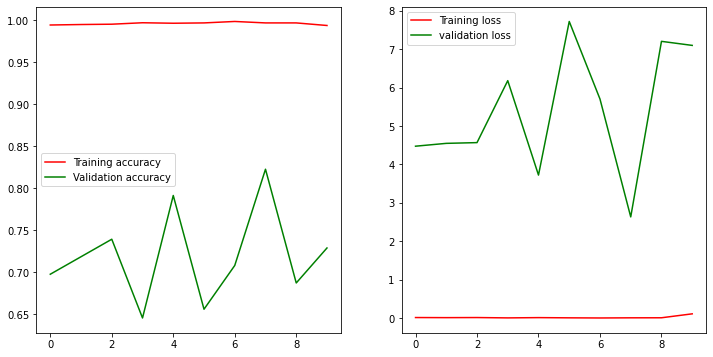

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.94      0.34      0.50       188
   PNEUMONIA       0.71      0.99      0.83       312

    accuracy                           0.74       500
   macro avg       0.83      0.66      0.66       500
weighted avg       0.80      0.74      0.70       500



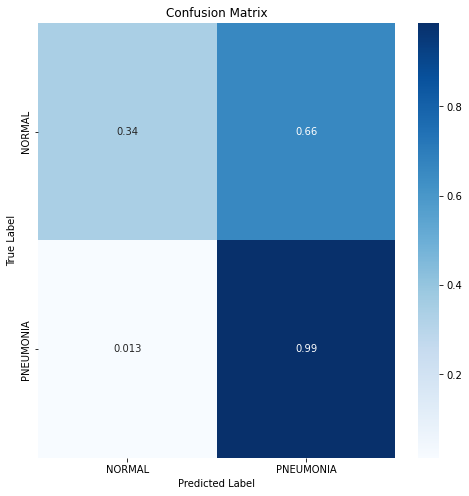

In [132]:
model_eval(model_1, history)

In [143]:
def model_2nd():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(80,80,3)))
    model_2.add(MaxPooling2D((2,2)))

    model_2.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model_2.add(MaxPooling2D((2,2)))

    model_2.add(Conv2D(128,kernel_size=(3,3), padding="same", activation="relu"))
    model_2.add(MaxPooling2D((2,2)))

    model_2.add(Conv2D(128,(3,3), padding="same", activation="relu"))
    model_2.add(MaxPooling2D(2,2))

    #Flattening the layer before fully connected layers
    model_2.add(Flatten())

    model_2.add(Dense(128, activation="relu"))
    model_2.add(Dropout(0.1))

    model_2.add(Dense(256, activation="relu"))
    model_2.add(Dense(512, activation="relu"))
    model_2.add(Dense(1, activation="sigmoid"))

    model_2.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

    model_2.summary()
    return model_2





In [144]:
model_2 = model_2nd()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 39, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 19, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 9, 9, 128)       

In [145]:
history = model_2.fit_generator(train_gen, epochs=10, steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, validation_data=val_gen)

Epoch 1/10
163/163 [==============================] - 70s 420ms/step - loss: 0.9640 - accuracy: 0.7306 - val_loss: 0.7069 - val_accuracy: 0.5208
Epoch 2/10
163/163 [==============================] - 57s 351ms/step - loss: 0.4461 - accuracy: 0.8150 - val_loss: 0.6088 - val_accuracy: 0.7083
Epoch 3/10
163/163 [==============================] - 57s 351ms/step - loss: 0.2544 - accuracy: 0.8957 - val_loss: 0.7372 - val_accuracy: 0.6979
Epoch 4/10
163/163 [==============================] - 63s 386ms/step - loss: 0.2044 - accuracy: 0.9160 - val_loss: 0.8114 - val_accuracy: 0.6562
Epoch 5/10
163/163 [==============================] - 72s 443ms/step - loss: 0.1941 - accuracy: 0.9369 - val_loss: 0.7307 - val_accuracy: 0.6354
Epoch 6/10
163/163 [==============================] - 61s 370ms/step - loss: 0.2532 - accuracy: 0.9047 - val_loss: 1.8332 - val_accuracy: 0.5833
Epoch 7/10
163/163 [==============================] - 60s 367ms/step - loss: 0.1247 - accuracy: 0.9521 - val_loss: 1.6582 - val_ac

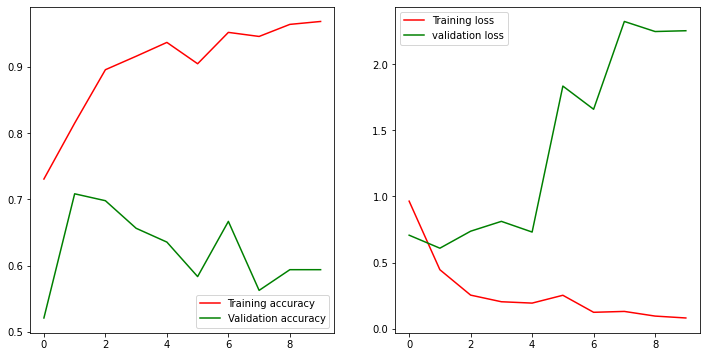

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       1.00      0.26      0.41       188
   PNEUMONIA       0.69      1.00      0.82       312

    accuracy                           0.72       500
   macro avg       0.85      0.63      0.61       500
weighted avg       0.81      0.72      0.66       500



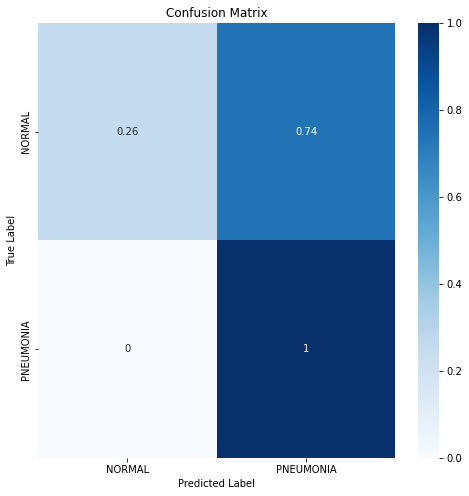

In [146]:
model_eval(model_2, history)

In [157]:
pneumonia = len(os.listdir(os.path.join(train_folder, "PNEUMONIA")))
normal = len(os.listdir(os.path.join(train_folder+ "/NORMAL")))
pneumonia, normal

(3876, 1342)

In [158]:
class_1 = pneumonia / (normal+pneumonia)
class_2 = normal / (normal+pneumonia)

class_weight = {0:class_1, 1:class_2}

print(f"Weight for class 0: {class_1:.2f}")
print(f"Weight for class 1: {class_2:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [149]:
def model_3rd():
    model_3 = Sequential()

    model_3.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(80,80,3)))
    model_3.add(MaxPooling2D((2,2)))
    
    model_3.add(Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
    model_3.add(MaxPooling2D((2,2)))

    model_3.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    model_3.add(MaxPooling2D((2,2)))

    model_3.add(Conv2D(128,(3,3), padding="same", activation="relu"))
    model_3.add(MaxPooling2D((2,2)))

    model_3.add(Dropout(0.2))

    model_3.add(Flatten())

    model_3.add(Dense(128, activation="relu"))

    model_3.add(Dropout(0.2))

    model_3.add(Dense(128, activation="relu"))
    model_3.add(Dense(512, activation="relu"))
    model_3.add(Dense(1, activation="sigmoid"))

    model_3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    model_3.summary()

    return model_3


In [150]:
model_3 = model_3rd()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 10, 10, 128)     

In [159]:
model_3.fit_generator(train_gen,epochs=20, steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, validation_data=val_gen, class_weight=class_weight )

Epoch 1/20
163/163 [==============================] - 79s 482ms/step - loss: 0.2851 - accuracy: 0.4214 - val_loss: 0.6929 - val_accuracy: 0.5208
Epoch 2/20
163/163 [==============================] - 68s 417ms/step - loss: 8.1587 - accuracy: 0.5504 - val_loss: 0.7104 - val_accuracy: 0.4792
Epoch 3/20
163/163 [==============================] - 69s 420ms/step - loss: 0.2172 - accuracy: 0.6785 - val_loss: 0.8973 - val_accuracy: 0.6146
Epoch 4/20
163/163 [==============================] - 62s 383ms/step - loss: 0.1724 - accuracy: 0.8016 - val_loss: 1.4649 - val_accuracy: 0.6146
Epoch 5/20
163/163 [==============================] - 75s 456ms/step - loss: 0.1183 - accuracy: 0.8499 - val_loss: 0.9061 - val_accuracy: 0.6979
Epoch 6/20
163/163 [==============================] - 123s 756ms/step - loss: 0.0830 - accuracy: 0.8974 - val_loss: 1.4718 - val_accuracy: 0.6146
Epoch 7/20
163/163 [==============================] - 144s 881ms/step - loss: 0.0880 - accuracy: 0.9003 - val_loss: 1.3232 - val_

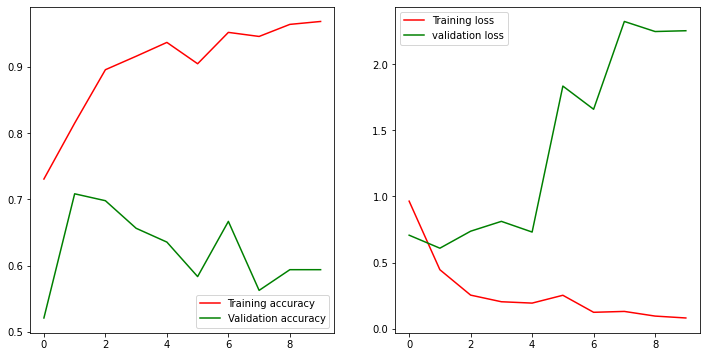

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.93      0.54      0.68       188
   PNEUMONIA       0.78      0.97      0.87       312

    accuracy                           0.81       500
   macro avg       0.85      0.76      0.78       500
weighted avg       0.84      0.81      0.80       500



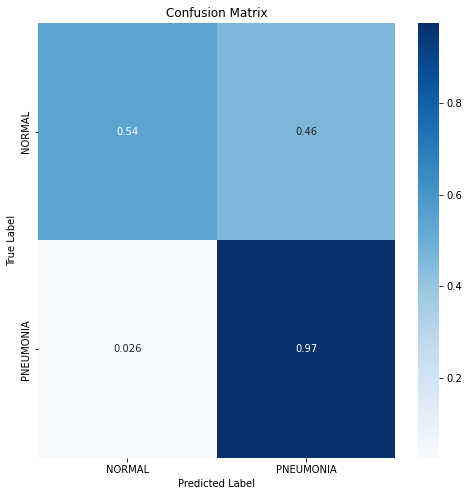

In [160]:
model_eval(model_3, history)

In [161]:
model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(80,80,3))
model_vgg16.trainable=False
model_vgg16.summary()


58900480/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
______________________________________________________________

In [164]:
def vgg_model():
    vgg_model = Sequential()
    vgg_model.add(model_vgg16)
    vgg_model.add(Flatten())

    vgg_model.add(Dropout(0.2))
    vgg_model.add(Dense(128, activation="relu"))
    vgg_model.add(Dense(64, activation="relu"))
    vgg_model.add(Dense(1, activation="sigmoid"))
    vgg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return vgg_model

In [165]:
vgg_model = vgg_model()

In [174]:
history = vgg_model.fit_generator(train_gen, epochs=20, steps_per_epoch = train_size// batch_size, validation_steps = val_size//batch_size, validation_data=val_gen, class_weight=class_weight)

Epoch 1/20
163/163 [==============================] - 160s 984ms/step - loss: 0.0404 - accuracy: 0.9561 - val_loss: 0.5374 - val_accuracy: 0.8646
Epoch 2/20
163/163 [==============================] - 150s 918ms/step - loss: 0.0342 - accuracy: 0.9626 - val_loss: 0.6530 - val_accuracy: 0.8646
Epoch 3/20
163/163 [==============================] - 140s 856ms/step - loss: 0.0286 - accuracy: 0.9686 - val_loss: 0.4858 - val_accuracy: 0.8854
Epoch 4/20
163/163 [==============================] - 136s 831ms/step - loss: 0.0331 - accuracy: 0.9640 - val_loss: 0.4178 - val_accuracy: 0.8958
Epoch 5/20
163/163 [==============================] - 126s 773ms/step - loss: 0.0285 - accuracy: 0.9709 - val_loss: 0.6601 - val_accuracy: 0.8750
Epoch 6/20
163/163 [==============================] - 123s 754ms/step - loss: 0.0263 - accuracy: 0.9695 - val_loss: 1.0188 - val_accuracy: 0.8229
Epoch 7/20
163/163 [==============================] - 275s 2s/step - loss: 0.0258 - accuracy: 0.9726 - val_loss: 0.3699 - va

In [173]:
history.history

{'loss': [0.1436442881822586,
  0.07743466645479202,
  0.07129428535699844,
  0.05404972657561302,
  0.05379002168774605,
  0.046313121914863586,
  0.05020603910088539,
  0.04724113643169403,
  0.05570945888757706,
  0.05173185095191002,
  0.04303797334432602,
  0.042869821190834045,
  0.041591331362724304,
  0.03644422069191933,
  0.03676106035709381,
  0.04222332313656807,
  0.04282132163643837,
  0.03717399016022682,
  0.03632060065865517,
  0.036414481699466705],
 'accuracy': [0.8611963391304016,
  0.9219708442687988,
  0.931556761264801,
  0.9472776055335999,
  0.9455521702766418,
  0.9534125924110413,
  0.9459356069564819,
  0.9505367875099182,
  0.9411426186561584,
  0.9445935487747192,
  0.952262282371521,
  0.9547545909881592,
  0.9589723944664001,
  0.9624233245849609,
  0.9639570713043213,
  0.9513036608695984,
  0.9580138325691223,
  0.9578220844268799,
  0.9624233245849609,
  0.9589723944664001]}

In [ ]:
test = test_val.flow_from_directory(test_folder, target_size=(80,80,3),subset="training",batch_size=batch_size,classes=["NORMAL", "PNEUMONIA"], class_mode="binary", shuffle=False)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor="val_loss", patience=3)
lr_plat = ReduceLROnPlateau(monitor="val_loss", factor=0.5)
callbacks=[early_stop, lr_plat]

In [ ]:
def model_4th():
    model_4 = Sequential()

    model_4.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(80,80,3)))
    model_4.add(MaxPooling2D((2,2)))

    model_4.add(Conv2D(128, (3,3), activation="relu", padiing="same"))
    model_4.add(MaxPooling2D((2,2)))

    model_4.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    model_4.add(MaxPooling2D((2,2)))

    model_4.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    model_4.add(MaxPooling2D((2,2)))

    model_4.add(Flatten())

    model_4.add(Dense(128, activation="relu"))
    model_4.add(Dense(256, activation="relu"))
    model_4.add(Dropout(0.1))
    model_4.add(Dense(512, activation="relu"))
    model_4.add(Dropout(0.2))

    model_4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    model_4.summary()
    return model_4

In [ ]:
model_4 = model_4th

In [ ]:
history = model_4.fit_generator(train_gen, epochs=20, epoch_per_step=train_size//batch_size, validation_steps=val_size//batch_size,validation_data=val_gen, class_weight=class_weight, callbacks=callbacks)

In [ ]:
X_test, y_test = next(test)

In [ ]:
label = y_test[4]
img = X_test[4]

#get model predict
pred =best_model.predict(np.array[img])
pred_class = int(pred.round())

print("True Class: ", label)
print("Predicted Class:", pred_class)
plt.imshow()
plt.show()
